### Goal: To find the top 3 best-performed classifiers for 'dense core' 
- Datasets:
    - The loaded features have been already scaled, splitted, transformed by Kernel PCA-cosine and clustered. 
    
- Plan: 
    1. Load and inspect the features and targets
    2. Seperate the observations in train/validate/test into cluster 'dense core' (0) and cluster 'satellites' (1). 
    3. Keep cluster 'dense core' in train/validate/test
    4. Define the top 10 most frequent MoA annotations in cluster 1

In [1]:
# import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain

# Logistic Regression (predict_proba)
from sklearn.linear_model import LogisticRegression

# Decision Tree (predict_proba)
from sklearn.tree import DecisionTreeClassifier

# Random Forest (predcit_proba)
from sklearn.ensemble import RandomForestClassifier

# Nearest Neighbors (predict_proba)
from sklearn.neighbors import KNeighborsClassifier

# Neural Net (predict_proba)
from sklearn.neural_network import MLPClassifier

# Naive Bayes (predict_proba)
from sklearn.naive_bayes import GaussianNB

# Linear SVM (predict)
from sklearn.svm import SVC

# QDA (predict_proba)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, log_loss

import model

### 1. Load and inspect the features and targets

In [3]:
# Load the features and targets

X_train_cos_two = pd.read_csv('X_train_cos_two.csv', index_col=0)
X_validate_cos_two = pd.read_csv('X_validate_cos_two.csv', index_col=0)
X_test_cos_two = pd.read_csv('X_test_cos_two.csv', index_col=0)

Y_train = pd.read_csv('Y_train.csv', index_col=0)
Y_validate = pd.read_csv('Y_validate.csv', index_col=0)
Y_test = pd.read_csv('Y_test.csv', index_col=0)

# Print their shapes
X_train_cos_two.shape, X_validate_cos_two.shape, X_test_cos_two.shape, \
Y_train.shape, Y_validate.shape, Y_test.shape

((15802, 51), (3951, 51), (2195, 51), (15802, 206), (3951, 206), (2195, 206))

In [4]:
# Make sure the index match between X and Y

print((X_train_cos_two.index == Y_train.index).sum())
print((X_validate_cos_two.index == Y_validate.index).sum())
print((X_test_cos_two.index == Y_test.index).sum())

15802
3951
2195


In [5]:
# Take a peek at train features
X_train_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,-0.046098,-0.000499,0.032700,-0.090504,0.031419,-0.122123,0.024048,-0.122287,-0.012305,0
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,0.004647,0.002614,0.044699,0.061037,-0.002453,-0.014456,-0.020474,0.008282,0.037586,0


In [6]:
# Take a peek at validate features
X_validate_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_c3dcb40f3,-0.095262,0.304736,0.249410,-0.111197,0.057856,-0.063222,-0.016120,0.054633,0.165032,-0.038657,...,0.059683,-0.02128,-0.080636,-0.022468,0.010193,0.023441,-0.028692,0.053862,0.072372,0
id_f8620e4ca,-0.134914,0.106835,0.270053,-0.107940,-0.040384,-0.194361,0.152628,-0.014447,-0.029834,0.057959,...,-0.009219,-0.00217,-0.007370,-0.027853,-0.031368,0.000323,-0.065433,-0.050758,0.048525,0


In [7]:
# Take a peek at test features
X_test_cos_two.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,cluster
id_e46fab631,-0.264368,-0.005719,0.092971,-0.328395,0.007406,-0.018449,-0.042042,-0.055791,0.082492,-0.004333,...,0.042677,0.028871,-0.023006,0.006879,-0.084260,0.030489,-0.015435,-0.090901,0.042381,0
id_354d3994d,0.392137,-0.125651,-0.209954,0.156944,-0.183358,0.266505,0.519936,0.154461,0.052577,0.050146,...,-0.022478,0.020033,-0.052790,-0.043385,0.012011,-0.038902,-0.025513,-0.013596,0.009735,1


**Takeaways**: Features and labels are successfully imported.

### 2. Seperate the observations into cluster 1 (dense core) and cluster 2 (satellites)

In [8]:
# Concat features and labels together

train = pd.concat([X_train_cos_two, Y_train], axis=1)
validate = pd.concat([X_validate_cos_two, Y_validate], axis=1)
test = pd.concat([X_test_cos_two, Y_test], axis=1)

# Print their shapes
train.shape, validate.shape, test.shape

((15802, 257), (3951, 257), (2195, 257))

In [11]:
# Seperate the train based on cluster labels

# Create the mask for the dense core
mask_core = (train.cluster == 0)

# Subtract the dense core
train_core = train[mask_core]

# Print the shape
print(train_core.shape)

# Take a peek at the df
train_core.head()

(13558, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,-0.116704,-0.175076,-0.216695,0.093239,0.098658,-0.023396,-0.040551,-0.069963,0.081209,-0.049178,...,0,0,0,0,0,0,0,0,0,0
id_d8f5ca938,-0.108337,0.198954,-0.001508,0.331887,-0.138065,-0.079667,-0.033503,-0.174493,-0.137442,0.065832,...,0,0,0,0,1,0,0,0,0,0
id_c4eaa645d,0.113585,-0.318411,0.101633,-0.034343,0.128269,-0.208788,-0.105685,0.149461,-0.098587,0.329119,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Seperate the validate based on cluster labels

# Create the mask for the dense core
mask_core = (validate.cluster == 0)

# Subtract the dense core
validate_core = validate[mask_core]

# Print the shape
print(validate_core.shape)

# Take a peek at the df
validate_core.head()

(3410, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_c3dcb40f3,-0.095262,0.304736,0.249410,-0.111197,0.057856,-0.063222,-0.016120,0.054633,0.165032,-0.038657,...,0,0,0,0,0,0,0,0,0,0
id_f8620e4ca,-0.134914,0.106835,0.270053,-0.107940,-0.040384,-0.194361,0.152628,-0.014447,-0.029834,0.057959,...,0,0,0,0,0,0,0,0,0,0
id_018eabd67,0.210457,0.239365,-0.164920,0.034534,0.272117,0.167090,0.046586,-0.259783,-0.143833,0.017687,...,0,0,0,0,0,0,0,0,0,0
id_1b31d6454,-0.037920,0.085548,0.091110,0.153108,-0.060493,-0.090420,-0.137237,0.078051,-0.030707,0.072345,...,0,0,0,0,0,0,0,0,0,0
id_4157cd98a,-0.108509,0.067244,-0.064803,-0.172227,-0.004254,-0.012358,-0.054628,0.094533,0.012555,0.065035,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Seperate the test based on cluster labels

# Create the mask for the dense core
mask_core = (test.cluster == 0)

# Subtract the dense core
test_core = test[mask_core]

# Print the shape
print(test_core.shape)

# Take a peek at the df
test_core.head()

(1892, 257)


,0,1,2,3,4,5,6,7,8,9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_e46fab631,-0.264368,-0.005719,0.092971,-0.328395,0.007406,-0.018449,-0.042042,-0.055791,0.082492,-0.004333,...,0,0,0,0,0,0,0,0,0,0
id_5c852c5fa,-0.113353,-0.292529,-0.019310,-0.156830,-0.081259,0.043071,0.028983,0.122399,0.071044,-0.084348,...,0,0,0,0,0,0,0,0,0,0
id_76de9b673,-0.022017,0.211754,-0.149465,-0.067840,0.140077,0.033733,0.054614,-0.075482,-0.032314,0.027665,...,0,0,0,0,0,0,0,0,0,0
id_5381a8f79,0.237520,0.262443,0.061341,-0.073582,0.029755,0.070180,0.059589,-0.051466,0.136650,0.087285,...,0,0,0,0,0,0,0,0,0,0
id_df1a8d0aa,0.009617,0.105377,-0.051351,-0.286780,0.205990,0.076437,0.112342,-0.079288,0.052905,0.021284,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Subtract the features: don't include the cluster column

X_train_core = train_core.iloc[:, 0:50]
X_validate_core = validate_core.iloc[:, 0:50]
X_test_core = test_core.iloc[:, 0:50]

# Print the shapes
X_train_core.shape, X_validate_core.shape, X_test_core.shape

((13558, 50), (3410, 50), (1892, 50))

In [26]:
# Subtract the targets: don't include the cluster column

Y_train_core = train_core.iloc[:, 51:]
Y_validate_core = validate_core.iloc[:, 51:]
Y_test_core = test_core.iloc[:, 51:]

# Print the shapes
Y_train_core.shape, Y_validate_core.shape, Y_test_core.shape

((13558, 206), (3410, 206), (1892, 206))

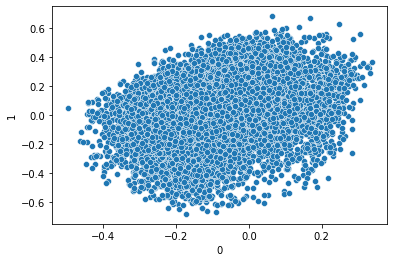

In [29]:
# Quick viz to confirm the correct separation

sns.scatterplot(data=X_train_core, x='0', y='1')
plt.show()

**Takeaways**: The cluster 'dense core' are successfully substracted from train/validate/test.